## Murine bone-marrow derived macrophages

https://data.broadinstitute.org/bbbc/BBBC020/

## Make a torch dataset

In [1]:
from segmentation.datasets import BroadDataset

### Show some images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#base = '/Users/nicholassofroniew/Documents/BBBC/BBBC020_v1/BBBC020_v1-cells'
base = '/Users/nicholassofroniew/Documents/DATA/neurofinder/localcorr'
train_dataset = BroadDataset(base, 'train')

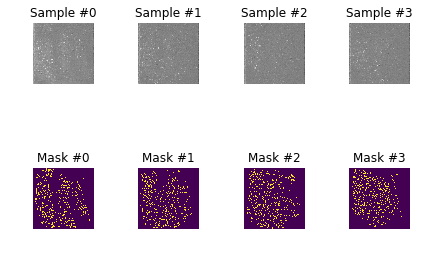

In [4]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [5]:
type(img)

PIL.Image.Image

In [6]:
from numpy import asarray
print(asarray(img).max())
print(asarray(mask).max())

255
255


## Define transforms

In [7]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

joint_transform = extended_transforms.Compose([
    extended_transforms.RandomHorizontallyFlip(),
    extended_transforms.RandomVerticallyFlip()
#    extended_transforms.CenterCrop(512),
#    extended_transforms.RandomRotate(45),
#    extended_transforms.RandomWarp(5, 20)
])

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     ])
target_transform = extended_transforms.MaskToTensor()

In [8]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform)

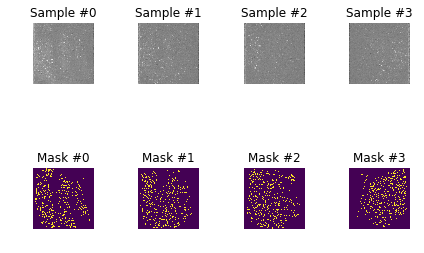

In [9]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [10]:
type(img)

PIL.Image.Image

In [11]:
from numpy import asarray
print(asarray(img).max())
print(asarray(mask).max())

255
255


In [12]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [13]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

## Load network

In [14]:
from segmentation.model import UNet

In [15]:
net = UNet(1)

In [16]:
net.train()

UNet (
  (enc1): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc2): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc3): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     

### Define loss function and optimizer

In [17]:
from segmentation.utilities import mIoULoss, CrossEntropyLoss2d, BCELoss2d

In [18]:
from torch import nn
criterion = mIoULoss(size_average=False)
#criterion = nn.NLLLoss2d()
#criterion = nn.BCEWithLogitsLoss()

In [19]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Pass data throuhg network

In [27]:
import torch.nn.functional as F
from torch.autograd import Variable
img, mask = train_dataset[0]
tmp = Variable(mask).unsqueeze(0)
foo = net(Variable(img).unsqueeze(0)).squeeze(0)

In [28]:
print(tmp)
print(foo)
#print(bar)

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.LongTensor of size 1x512x512]

Variable containing:
( 0 ,.,.) = 
 -7.6353e-01 -1.4448e+00 -1.8423e+00  ...  -1.3012e+00 -1.1211e+00 -1.1419e+00
  7.2466e-01 -1.2738e-01 -6.8843e-01  ...  -6.5272e-01 -5.4340e-01 -9.6858e-01
  1.7044e+00  5.9907e-01 -1.8314e-01  ...  -2.8075e-01 -1.3794e-01 -5.2689e-01
                 ...                   ⋱                   ...                
 -3.3876e-01 -5.0492e-01 -4.0903e-01  ...  -3.5119e-01  2.4189e-01  1.0587e+00
 -6.8424e-02 -4.3748e-01 -4.8878e-01  ...  -2.8459e-01  3.3323e-01  1.0575e+00
 -1.3439e-01 -6.0546e-01 -5.8557e-01  ...  -3.7483e-01  2.0033e-01  8.7322e-01
[torch.FloatTensor of size 1x512x512]



In [29]:
loss = criterion(foo, tmp)
print(loss)

Variable containing:
 90.8709
[torch.FloatTensor of size 1]



In [30]:
loss.backward()

### Train network

In [31]:
val_dataset = BroadDataset(base, 'train', input_transform=input_transform, target_transform=target_transform)

In [32]:
valloader = DataLoader(val_dataset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [33]:
from segmentation.main import train, validate
from os.path import isdir, join
from os import mkdir

In [ ]:
save_epoch = 1
epochs = 2

for epoch in range(epochs):  # loop over the dataset multiple times
        train(trainloader, net, criterion, optimizer, epoch, 18)
        # save out model every n epochs
        if save_epoch is not None:
            if epoch % save_epoch == save_epoch-1:
                snapshot_name = 'model-%04d' % epoch
                save_path = join(base, 'models-local', snapshot_name)
                if not isdir(save_path):
                    mkdir(save_path)
                validate(valloader, net, criterion, optimizer, True, save_path)  

### Load and save model

In [34]:
import torch
from os.path import join
snapshot_name = 'model-2999/model'

In [35]:
#torch.save(net.state_dict(), join(base, 'models-local', snapshot_name + '.pth'))
#torch.save(optimizer.state_dict(), join(base, 'models', 'opt_' + snapshot_name + '.pth'))

In [36]:
netCompare = UNet(1)

In [37]:
netCompare.load_state_dict(torch.load(join(base, 'models', snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))
#optimizer.load_state_dict(torch.load(join(base, 'models', 'opt_' + snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))

In [38]:
netCompare.train();

### Look at perforance on validation set

In [39]:
from torch.autograd import Variable
img, mask = val_dataset[0]
output = netCompare(Variable(img).unsqueeze(0))

In [40]:
prediction = F.sigmoid(output)

46.8912


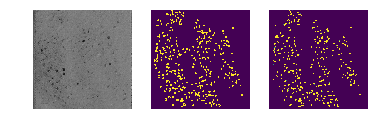

In [41]:
ax = plt.subplot(1,3,1);
plt.imshow(255*img.numpy().transpose(1,2,0))
ax.axis('off');
ax = plt.subplot(1,3,2);
plt.imshow(mask.numpy())
ax.axis('off');
ax = plt.subplot(1,3,3);
plt.imshow(prediction.squeeze(0).squeeze(0).data.numpy())
ax.axis('off');
loss = criterion(output, Variable(mask).unsqueeze(0))
print(loss.data.numpy()[0])

In [107]:
from skimage.io import imsave

In [47]:
correct = 0
total = 0
ind = 0
for data in valloader:
    images, labels = data
    outputs = netCompare(Variable(images))
    loss = criterion(outputs, Variable(labels)).data.numpy()[0]
    prediction = F.sigmoid(outputs)
    predict = prediction.squeeze(0).squeeze(0).data.numpy()
    #imsave(join(base, 'predictions','predict_%04d.tif' % ind), (255*predict).astype('uint8'), plugin='tifffile', photometric='minisblack')
    
    print(loss)
    total += labels.size(0)
    correct += loss
    ind += 1
    
print('Mean loss: %.2f %%' % (
    correct / total))

46.7921
46.2523
52.946
48.2735
52.9716
55.1984
56.0156
48.9356
49.4212
49.4519
54.5947
48.2415
48.2649
45.1823
32.7251
34.6654
50.4656
33.9754
Mean loss: 47.47 %


In [42]:
test_dataset = BroadDataset(base, 'test', input_transform=input_transform, target_transform=target_transform)

In [43]:
testloader = DataLoader(test_dataset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [45]:
from skimage.io import imsave

In [46]:
ind = 0
for data in testloader:
    images, labels = data
    outputs = netCompare(Variable(images))
    prediction = F.sigmoid(outputs)
    predict = prediction.squeeze(0).squeeze(0).data.numpy()
    imsave(join(base, 'test-model-2999','predict_%04d.tif' % ind), (255*predict).astype('uint8'), plugin='tifffile', photometric='minisblack')
    ind += 1

/Users/nicholassofroniew/Github/pytorch-segmentation/segmentation/transforms.py:17: RuntimeWarning: invalid value encountered in true_divide
  return torch.from_numpy(imgarray/imgarray.max()).long()
/Users/nicholassofroniew/Github/pytorch-segmentation/segmentation/transforms.py:17: RuntimeWarning: invalid value encountered in true_divide
  return torch.from_numpy(imgarray/imgarray.max()).long()
